In [1]:
from torchvision.transforms.v2 import ToTensor

VERSION = '001'
BATCHSIZE = 32
MAX_EPOCHS = 50
BACKBONE = "resnet50"
MODEL_NAME = "ResNet50_transfer"
NUM_WORKERS = 31

In [2]:

import os
from torchvision.transforms import Compose, Resize, InterpolationMode, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip
import torch
from torchvision import transforms
from code.classifier import PneumoniaClassifier, Config
import matplotlib.pyplot as plt
import numpy as np



In [3]:

# Load the TensorBoard extension
%reload_ext tensorboard
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [4]:
# Enable CUDA Launch Blocking
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# Set float32 matrix multiplication precision to 'medium' to utilize Tensor Cores
torch.set_float32_matmul_precision('medium')
torch.serialization.add_safe_globals([Compose, Resize, set, Config, InterpolationMode, ToTensor, Normalize, RandomHorizontalFlip])

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Tue Nov 26 23:05:02 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.90                 Driver Version: 565.90         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti   WDDM  |   00000000:02:00.0  On |                  N/A |
|  0%   45C    P8             13W /  285W |    1554MiB /  12282MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
from torchvision import transforms


config = Config(
    backbone_name="resnet18",
    transfer_learning=True,
    learning_rate=1e-4,
    batch_size=20,
    max_epochs=100,
    weight_decay=1e-4,
    dropout=0.5,
    num_workers=31,
    model_name="ResNet18_transfer",
    version="001",
    optimizer_name = "sgd"
)

model = PneumoniaClassifier(config)
model.train_model()

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\aszab\miniconda3\envs\pneumonia_detection\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name              | Type            | Params | Mode 
--------------------------------------------------------------
0 | accuracy          | BinaryAccuracy  | 0      | train
1 | precision         | BinaryPrecision | 0      | train
2 | recall            | BinaryRecall    | 0      | train
3 | f1                | BinaryF1Score   | 0      | train
4 | feature_extractor | Sequential      | 11.2 M | train
5 | dropout           | Dropout         | 0      | train
6 | classifier        | Linear          | 1.0 K  | train
--------------------------------------------------------

Epoch 0: 100%|██████████| 261/261 [01:36<00:00,  2.70it/s, v_num=0, train_loss_step=0.482, train_acc_step=0.680, train_precision_step=0.750, train_recall_step=0.854, train_f1_step=0.799]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 261/261 [01:37<00:00,  2.67it/s, v_num=0, train_loss_step=0.482, train_acc_step=0.680, train_precision_step=0.750, train_recall_step=0.854, train_f1_step=0.799, val_acc_epoch=0.680, val_precision_epoch=0.749, val_recall_epoch=0.854, val_f1_epoch=0.798]

Metric val_loss improved. New best score: 0.660


Epoch 1: 100%|██████████| 261/261 [01:33<00:00,  2.78it/s, v_num=0, train_loss_step=0.443, train_acc_step=0.789, train_precision_step=0.804, train_recall_step=0.946, train_f1_step=0.869, val_acc_epoch=0.680, val_precision_epoch=0.749, val_recall_epoch=0.854, val_f1_epoch=0.798]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 261/261 [01:35<00:00,  2.74it/s, v_num=0, train_loss_step=0.443, train_acc_step=0.789, train_precision_step=0.804, train_recall_step=0.946, train_f1_step=0.869, val_acc_epoch=0.788, val_precision_epoch=0.804, val_recall_epoch=0.946, val_f1_epoch=0.869]

Metric val_loss improved by 0.111 >= min_delta = 0.0. New best score: 0.549


Epoch 2: 100%|██████████| 261/261 [01:34<00:00,  2.75it/s, v_num=0, train_loss_step=0.799, train_acc_step=0.819, train_precision_step=0.837, train_recall_step=0.940, train_f1_step=0.885, val_acc_epoch=0.788, val_precision_epoch=0.804, val_recall_epoch=0.946, val_f1_epoch=0.869]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 261/261 [01:36<00:00,  2.71it/s, v_num=0, train_loss_step=0.799, train_acc_step=0.819, train_precision_step=0.837, train_recall_step=0.940, train_f1_step=0.885, val_acc_epoch=0.819, val_precision_epoch=0.836, val_recall_epoch=0.940, val_f1_epoch=0.885]

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 0.504


Epoch 3: 100%|██████████| 261/261 [01:34<00:00,  2.77it/s, v_num=0, train_loss_step=0.260, train_acc_step=0.835, train_precision_step=0.858, train_recall_step=0.932, train_f1_step=0.894, val_acc_epoch=0.819, val_precision_epoch=0.836, val_recall_epoch=0.940, val_f1_epoch=0.885]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 261/261 [01:35<00:00,  2.73it/s, v_num=0, train_loss_step=0.260, train_acc_step=0.835, train_precision_step=0.858, train_recall_step=0.932, train_f1_step=0.894, val_acc_epoch=0.834, val_precision_epoch=0.857, val_recall_epoch=0.932, val_f1_epoch=0.893]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.493


Epoch 4: 100%|██████████| 261/261 [01:35<00:00,  2.75it/s, v_num=0, train_loss_step=0.271, train_acc_step=0.854, train_precision_step=0.875, train_recall_step=0.936, train_f1_step=0.905, val_acc_epoch=0.834, val_precision_epoch=0.857, val_recall_epoch=0.932, val_f1_epoch=0.893]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 261/261 [01:36<00:00,  2.71it/s, v_num=0, train_loss_step=0.271, train_acc_step=0.854, train_precision_step=0.875, train_recall_step=0.936, train_f1_step=0.905, val_acc_epoch=0.853, val_precision_epoch=0.875, val_recall_epoch=0.936, val_f1_epoch=0.904]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.491


Epoch 5: 100%|██████████| 261/261 [01:34<00:00,  2.77it/s, v_num=0, train_loss_step=0.148, train_acc_step=0.848, train_precision_step=0.871, train_recall_step=0.934, train_f1_step=0.902, val_acc_epoch=0.853, val_precision_epoch=0.875, val_recall_epoch=0.936, val_f1_epoch=0.904]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 261/261 [01:35<00:00,  2.73it/s, v_num=0, train_loss_step=0.148, train_acc_step=0.848, train_precision_step=0.871, train_recall_step=0.934, train_f1_step=0.902, val_acc_epoch=0.848, val_precision_epoch=0.870, val_recall_epoch=0.935, val_f1_epoch=0.901]

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.453


Epoch 6: 100%|██████████| 261/261 [01:34<00:00,  2.76it/s, v_num=0, train_loss_step=0.163, train_acc_step=0.866, train_precision_step=0.886, train_recall_step=0.940, train_f1_step=0.913, val_acc_epoch=0.848, val_precision_epoch=0.870, val_recall_epoch=0.935, val_f1_epoch=0.901] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 261/261 [01:35<00:00,  2.72it/s, v_num=0, train_loss_step=0.163, train_acc_step=0.866, train_precision_step=0.886, train_recall_step=0.940, train_f1_step=0.913, val_acc_epoch=0.866, val_precision_epoch=0.886, val_recall_epoch=0.941, val_f1_epoch=0.912]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.451


Epoch 7: 100%|██████████| 261/261 [01:34<00:00,  2.76it/s, v_num=0, train_loss_step=0.303, train_acc_step=0.858, train_precision_step=0.888, train_recall_step=0.926, train_f1_step=0.906, val_acc_epoch=0.866, val_precision_epoch=0.886, val_recall_epoch=0.941, val_f1_epoch=0.912]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 261/261 [01:36<00:00,  2.72it/s, v_num=0, train_loss_step=0.303, train_acc_step=0.858, train_precision_step=0.888, train_recall_step=0.926, train_f1_step=0.906, val_acc_epoch=0.858, val_precision_epoch=0.887, val_recall_epoch=0.926, val_f1_epoch=0.906]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.444


Epoch 8: 100%|██████████| 261/261 [01:33<00:00,  2.79it/s, v_num=0, train_loss_step=0.272, train_acc_step=0.869, train_precision_step=0.897, train_recall_step=0.930, train_f1_step=0.913, val_acc_epoch=0.858, val_precision_epoch=0.887, val_recall_epoch=0.926, val_f1_epoch=0.906]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 261/261 [01:34<00:00,  2.77it/s, v_num=0, train_loss_step=0.186, train_acc_step=0.876, train_precision_step=0.901, train_recall_step=0.936, train_f1_step=0.918, val_acc_epoch=0.869, val_precision_epoch=0.897, val_recall_epoch=0.930, val_f1_epoch=0.913] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 261/261 [01:35<00:00,  2.74it/s, v_num=0, train_loss_step=0.186, train_acc_step=0.876, train_precision_step=0.901, train_recall_step=0.936, train_f1_step=0.918, val_acc_epoch=0.875, val_precision_epoch=0.900, val_recall_epoch=0.936, val_f1_epoch=0.918]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.443


Epoch 10: 100%|██████████| 261/261 [01:32<00:00,  2.81it/s, v_num=0, train_loss_step=0.477, train_acc_step=0.877, train_precision_step=0.905, train_recall_step=0.931, train_f1_step=0.918, val_acc_epoch=0.875, val_precision_epoch=0.900, val_recall_epoch=0.936, val_f1_epoch=0.918]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 261/261 [01:34<00:00,  2.77it/s, v_num=0, train_loss_step=0.347, train_acc_step=0.880, train_precision_step=0.904, train_recall_step=0.939, train_f1_step=0.921, val_acc_epoch=0.876, val_precision_epoch=0.904, val_recall_epoch=0.931, val_f1_epoch=0.918] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 261/261 [01:32<00:00,  2.82it/s, v_num=0, train_loss_step=0.219, train_acc_step=0.881, train_precision_step=0.905, train_recall_step=0.938, train_f1_step=0.921, val_acc_epoch=0.880, val_precision_epoch=0.903, val_recall_epoch=0.939, val_f1_epoch=0.921]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.426


Epoch 13: 100%|██████████| 261/261 [01:32<00:00,  2.81it/s, v_num=0, train_loss_step=0.214, train_acc_step=0.881, train_precision_step=0.910, train_recall_step=0.932, train_f1_step=0.921, val_acc_epoch=0.881, val_precision_epoch=0.904, val_recall_epoch=0.938, val_f1_epoch=0.921]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 261/261 [01:33<00:00,  2.78it/s, v_num=0, train_loss_step=0.512, train_acc_step=0.876, train_precision_step=0.907, train_recall_step=0.927, train_f1_step=0.917, val_acc_epoch=0.880, val_precision_epoch=0.909, val_recall_epoch=0.932, val_f1_epoch=0.920] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 261/261 [01:33<00:00,  2.78it/s, v_num=0, train_loss_step=0.463, train_acc_step=0.892, train_precision_step=0.917, train_recall_step=0.940, train_f1_step=0.928, val_acc_epoch=0.875, val_precision_epoch=0.906, val_recall_epoch=0.928, val_f1_epoch=0.917] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|█████

Monitored metric val_loss did not improve in the last 3 records. Best score: 0.426. Signaling Trainer to stop.


Epoch 15: 100%|██████████| 261/261 [01:35<00:00,  2.74it/s, v_num=0, train_loss_step=0.463, train_acc_step=0.892, train_precision_step=0.917, train_recall_step=0.940, train_f1_step=0.928, val_acc_epoch=0.892, val_precision_epoch=0.916, val_recall_epoch=0.940, val_f1_epoch=0.928]


In [7]:
checkpoint = torch.load(f"../checkpoints/{config.model_name}.ckpt", weights_only=True)

# Access the metadata
metadata = checkpoint.get("metadata", {})

In [9]:
# Initialize the model
#model = PneumoniaClassifier(config, transform)
# Test the model
metadata = model.test_model(f"../checkpoints/{config.model_name}.ckpt")

# Print the metadata
print(metadata)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 32/32 [00:09<00:00,  3.27it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.7868589758872986
      test_acc_step         0.6271810531616211
      test_f1_epoch         0.8497174978256226
      test_f1_step          0.43944916129112244
        test_loss           0.40907812118530273
  test_precision_epoch      0.7595959305763245
   test_precision_step      0.3570745587348938
    test_recall_epoch        0.964102566242218
    test_recall_step        0.6322962641716003
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
None


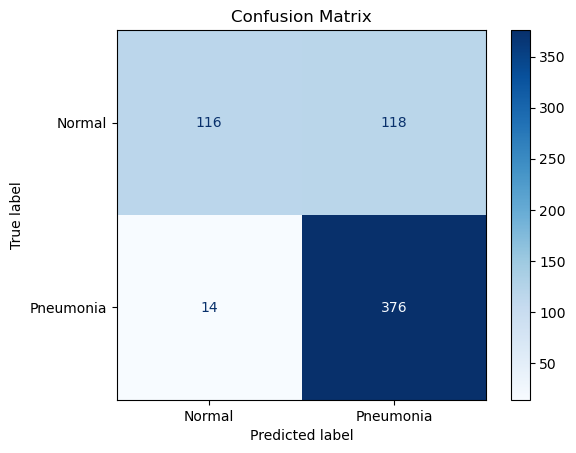

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, dataloader, class_names):
    all_preds = []
    all_labels = []

    # Get predictions and true labels
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.cuda()  # Move data to GPU if available
            labels = labels.cuda()
            preds = torch.argmax(model(data), dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

# Call this after training/testing
plot_confusion_matrix(model, model.test_loader, class_names=["Normal", "Pneumonia"])

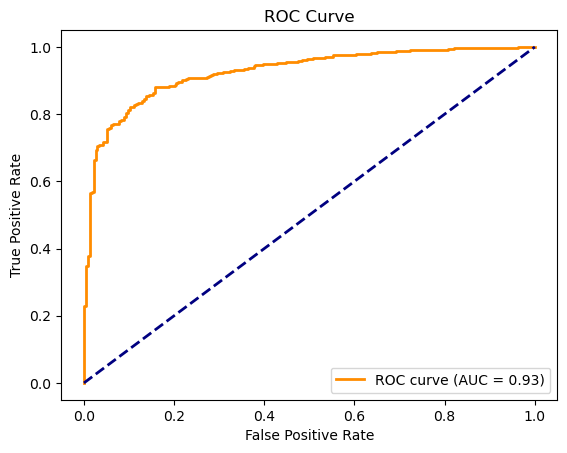

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_auc(model, dataloader):
    all_preds = []
    all_labels = []

    # Get predictions and true labels
    model.eval()
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.cuda()
            labels = labels.cuda()
            preds = model(data)
            probs = torch.softmax(preds, dim=1)[:, 1]  # Probabilities for class 1
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_preds)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Call this after training/testing
plot_roc_auc(model, model.test_loader)

In [15]:
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

def visualize_gradcam(model, dataloader, target_layer="feature_extractor.7"):
    model.eval()

    # Initialize Grad-CAM
    cam_extractor = SmoothGradCAMpp(model, target_layer=target_layer)

    # Pick one image from the dataloader
    data, labels = next(iter(dataloader))
    data = data.cuda()
    labels = labels.cuda()

    # Get predictions and CAM
    preds = model(data)
    class_idx = preds.argmax(dim=1).item()  # Predicted class index for the first image

    # Generate CAM for the predicted class
    cams = cam_extractor(class_idx, preds)

    # Overlay CAM on the original image
    for i in range(len(data)):
        heatmap = cams[target_layer][i]
        original_image = to_pil_image(data[i].cpu())
        heatmap_image = to_pil_image(heatmap, mode="F")

        # Overlay heatmap on the original image
        result = overlay_mask(original_image, heatmap_image, alpha=0.5)
        plt.imshow(result)
        plt.title(f"Grad-CAM for label {labels[i].item()} (Pred: {class_idx})")
        plt.axis("off")
        plt.show()

# Call this after training
visualize_gradcam(model, model.test_loader)


PneumoniaClassifier(
  (accuracy): BinaryAccuracy()
  (precision): BinaryPrecision()
  (recall): BinaryRecall()
  (f1): BinaryF1Score()
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), 

RuntimeError: cannot register a hook on a tensor that doesn't require gradient